In [1]:
!git clone https://github.com/Mike030668/Project_glass.git -q

In [2]:
if 'google.colab' in str(get_ipython()):
  print('Running on CoLab')
  import os
  os.chdir('/content/Project_glass')
  os.getcwd()

else:
  print('Not running on CoLab')

Running on CoLab


In [3]:
from prepare_data.const_predprice import  TARGET_COLS, BASE_COLS, BATCH_SIZE, DEPTH, PREDICT_LAG
from prepare_data.constants import GLASS_COLS, FUTURE, MAKE_LOG
from prepare_data.utils import future_sequence
import numpy as np # библиотека нампи
import matplotlib.pyplot as plt # библиотека матплотлиб для отрисовки
from IPython.display import clear_output # очистка вывода в ячейке
import joblib
import pandas as pd # библиотека пандас
import tensorflow as tf           # библиотека машинного обучения

# load prepared train data

data prepared with vcs note makedata_vsc.ipynb

In [4]:
x_train_sc = np.load("./predprice/x_train_sc.npy")
x_val_sc = np.load("./predprice/x_val_sc.npy")
y_train_sc = np.load("./predprice/y_train_sc.npy")
y_val_sc = np.load("./predprice/y_val_sc.npy")

In [5]:
# Для генерации выборки временных рядов
TSG = tf.keras.preprocessing.sequence.TimeseriesGenerator

# Создаем генератор для обучения
train_datagen = TSG(x_train_sc, y_train_sc,          # В качестве параметров наши выборки
                    length = DEPTH,            # Анализируем по 21 прошедшим точкам
                    sampling_rate = 1,         # Для каждой точки
                    batch_size = BATCH_SIZE)   # Размер batch, который будем скармливать модели

# Создаем аналогичный генератор для валидации при обучении
val_datagen = TSG(x_val_sc, y_val_sc,                # В качестве параметров наши выборки
                    length = DEPTH,            # Анализируем по 21 прошедшим точкам
                    sampling_rate = 1,         # Для каждой точки
                    batch_size = BATCH_SIZE)   # Размер batch, который будем скармливать модели

print(train_datagen[0][0].shape,
      val_datagen[0][1].shape)

# Создадим генератор проверочной выборки, из которой потом вытащим xVal, yVal для проверки/оценки
DataGen = TSG(x_val_sc, y_val_sc,              # В качестве параметров наши выборки
              length = DEPTH,            # Анализируем по 21 прошедшим точкам
              sampling_rate = 1,         # Для каждой точки
              batch_size = len(x_val_sc))   # Размер batch будет равен длине нашей выборки


# сформируем сами массивы для проверки
XVAL, YVAL = [], []
for i in DataGen:
  XVAL.append(i[0])
  YVAL.append(i[1])

# так как это список объектов
# мы вытаскиваем нужный нам
XVAL = np.array(XVAL)[0]
YVAL = np.array(YVAL)[0]
print(XVAL.shape,YVAL.shape)

(64, 32, 53) (64, 5)
(530, 32, 53) (530, 5)


In [6]:
from construct_model.make_models import baseline, model_prepprice_path_colab

model= baseline(input_shape = XVAL.shape[1:],
                    pred_num = PREDICT_LAG,
                    activ_out = "linear",
                    depth= DEPTH)


In [7]:
# понижение шага
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                 mode='min',
                                                 factor = 0.8,
                                                 patience = 3,
                                                 min_lr = 1e-9,
                                                 verbose = 1)

# остановка
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    verbose=1,
    patience=10,
    mode='min',
    restore_best_weights=True)

path_model = model_prepprice_path_colab

# Сохранение модели
checkpoint  = tf.keras.callbacks.ModelCheckpoint(
                        filepath = path_model,
                        #save_weights_only=True,
                        monitor='val_loss',
                        mode='min',
                        save_best_only=True
                        )
# оптимизатор
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=1e-3)

# функция потерь
loss = tf.keras.losses.Huber() #.MSE #
model.compile(optimizer = optimizer, loss = loss, metrics=['mae', 'mape'])

In [8]:
# обучение модели вашей
history = model.fit(train_datagen,                  # генератор данных для обучения
                    validation_data = val_datagen, # генератор данных для проверки
                    epochs = 200,
                    callbacks=[early_stopping, reduce_lr, checkpoint],
                    verbose = 1)

Epoch 1/200
34/34 [==============================] - 34s 616ms/step - loss: 0.1297 - mae: 0.4070 - mape: 147480.1562 - val_loss: 0.0357 - val_mae: 0.2205 - val_mape: 51.1841 - lr: 0.0010
Epoch 2/200
34/34 [==============================] - 11s 329ms/step - loss: 0.0381 - mae: 0.2166 - mape: 137979.0781 - val_loss: 0.0130 - val_mae: 0.1318 - val_mape: 27.0235 - lr: 0.0010
Epoch 3/200
34/34 [==============================] - 11s 338ms/step - loss: 0.0257 - mae: 0.1790 - mape: 193245.2656 - val_loss: 0.0067 - val_mae: 0.0924 - val_mape: 18.9106 - lr: 0.0010
Epoch 4/200
34/34 [==============================] - 11s 342ms/step - loss: 0.0131 - mae: 0.1277 - mape: 67603.9531 - val_loss: 0.0050 - val_mae: 0.0794 - val_mape: 17.6104 - lr: 0.0010
Epoch 5/200
34/34 [==============================] - 11s 339ms/step - loss: 0.0097 - mae: 0.1098 - mape: 94635.1641 - val_loss: 0.0035 - val_mae: 0.0661 - val_mape: 13.7861 - lr: 0.0010
Epoch 6/200
34/34 [==============================] - 1s 20ms/step -

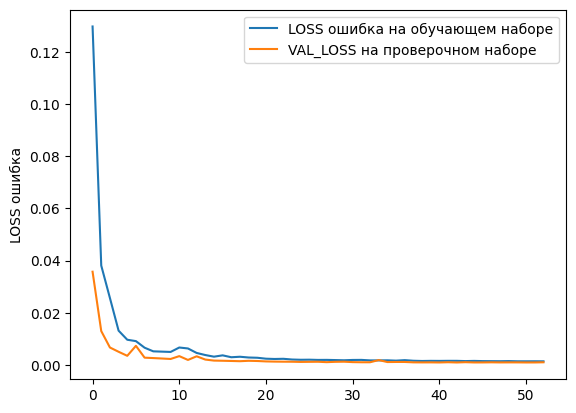

In [9]:
plt.plot(history.history['loss'],
         label='LOSS ошибка на обучающем наборе')
plt.plot(history.history['val_loss'],
         label='VAL_LOSS на проверочном наборе')
plt.ylabel('LOSS ошибка')
plt.legend()
plt.show()

## Оценка модели на VAL данных

In [10]:
from utils.estimation import get_scalepred, show_predict, auto_corr

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator MinMaxScaler from version 1.3.0 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


17/17 [==============================] - 2s 8ms/step


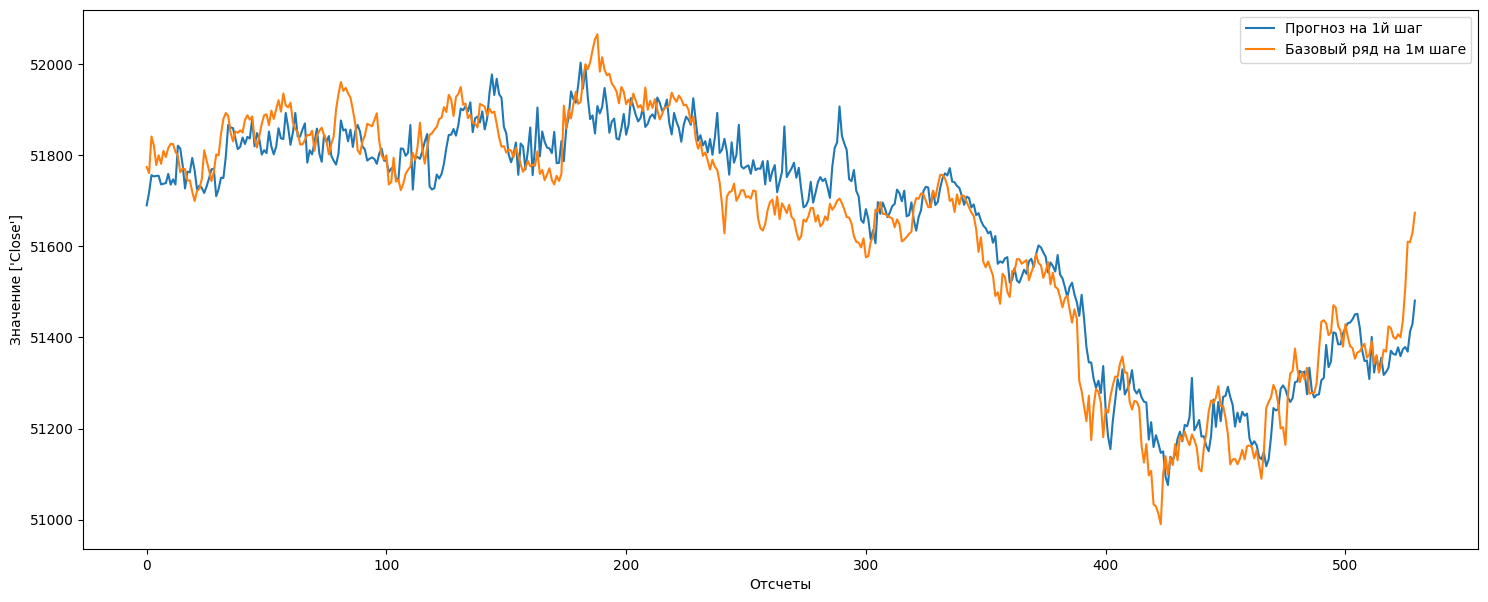

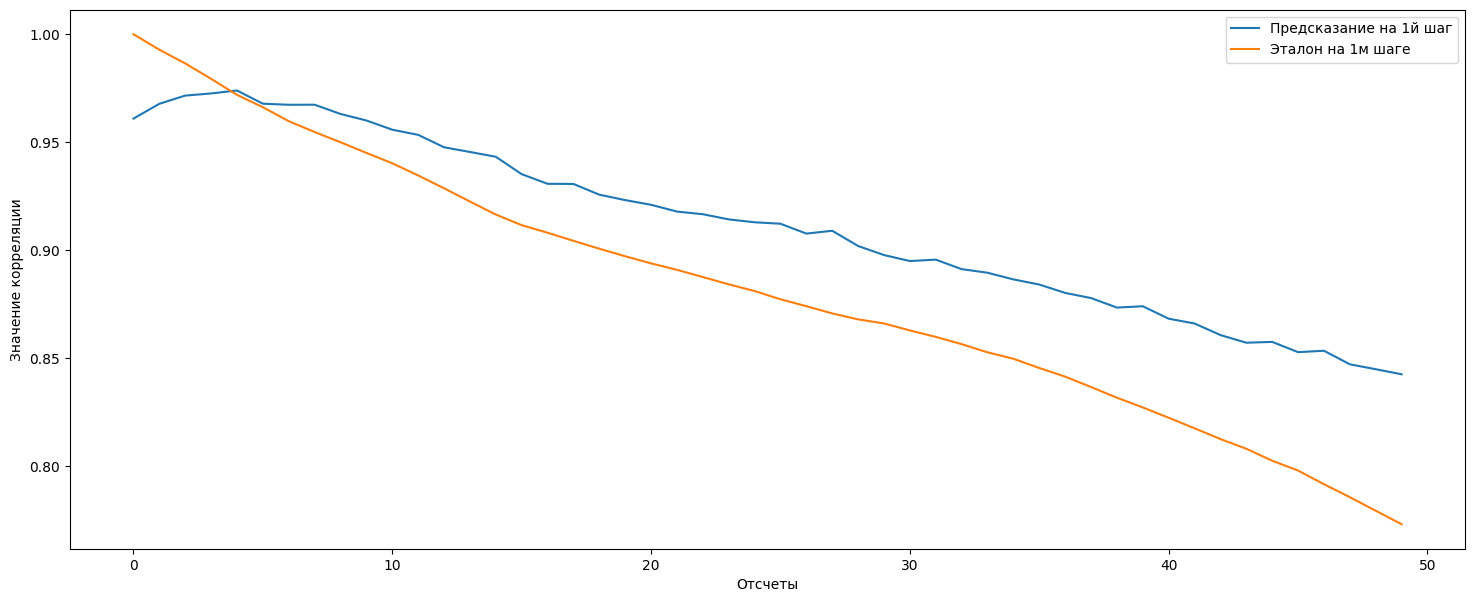

In [11]:
Y_SCAILER = joblib.load("/content/Project_glass/predprice/y_scailer.save")

# Прогнозируем данные текущей сетью
(y_pred_val, y_true_val) = get_scalepred(model, XVAL, YVAL, Y_SCAILER) #Прогнозируем данные

# Отображаем графики
show_predict(0,                    # начало периода
             y_true_val.shape[0],  # конец периода
             [0],                  # по предсказанию на какие шаги отрисовываем
             y_pred_val,           # предчказанные цены
             y_true_val,           # реальные цены
             TARGET_COLS,
             figsize=(18,7))

# Отображаем корреляцию
# Проверяем корреляцию на глубину PREDICT_LAG шагов
auto_corr([0],             # по предсказанию на какие шаги отрисовываем корреляцию
          50,              # на сколько шагов предсказание
          y_pred_val,      # предчказанные цены
          y_true_val       # реальные цены
          )

## Тест модели на TEST данных

## Готовим производные данных

In [12]:
all_data = pd.read_csv("/content/Project_glass/stock_data/BTCUSDT_1 _min.csv",
                       index_col=0, parse_dates=True )
print(f'Размер данных {all_data.shape}')

TEST_SIZE = 1500 # для теста откусим последние test_size значений
# Тестовая выборка для симуляции торговли в реальном времени
print(f'Тестовый датасет')
TEST_DATASET = all_data[FUTURE-PREDICT_LAG: FUTURE + TEST_SIZE]
print(TEST_DATASET.shape)


Размер данных (8317, 54)
Тестовый датасет
(1505, 54)


### Готовим данные из df_test

In [13]:
# колонки для тренировочной выборки
TRAIN_COLUMNS = BASE_COLS + GLASS_COLS
GLASS = len(GLASS_COLS)

X_MAIN_SCALER = joblib.load("/content/Project_glass/predprice/x_main_scailer.save")
X_GLASS_SCALER = joblib.load("/content/Project_glass/predprice/x_glass_scailer.save")


x_test = TEST_DATASET[TRAIN_COLUMNS].values

x_test_sc = np.zeros_like(x_test)
x_test_sc[:,:-GLASS] = X_MAIN_SCALER.transform(x_test[:,:-GLASS])  # трансформируем x_train
x_test_sc[:,-GLASS:] = X_GLASS_SCALER.transform(x_test[:,-GLASS:])  # трансформируем x_train


print(x_test_sc.shape)
x_test_sc[0]

(1505, 53)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator MinMaxScaler from version 1.3.0 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


array([5.12777110e-01, 5.30849761e-01, 5.59224585e-01, 2.85110270e-01,
       9.81148492e-01, 3.32928467e-01, 2.46189953e-01, 2.76011547e-01,
       3.84728429e-01, 5.69884801e-01, 8.26086957e-01, 8.26923077e-01,
       1.73076923e-01, 7.68037975e-01, 7.95371498e-01, 2.04628502e-01,
       2.69424791e-01, 5.21968014e-02, 3.65033934e-02, 2.31017217e-03,
       2.18156433e-04, 2.71053833e-03, 1.02877507e-02, 1.05207576e-01,
       2.47634639e-03, 5.61413268e-03, 4.30167247e-03, 1.17228464e-02,
       4.94310137e-02, 2.06234675e-02, 2.42760988e-02, 2.99349099e-02,
       1.06172952e-01, 5.20451816e-02, 1.11401650e-01, 1.32959219e-01,
       5.38009083e-02, 4.07870646e-02, 3.22196288e-03, 1.52350576e-02,
       3.11758592e-02, 4.21240090e-03, 2.56698160e-02, 4.14293135e-02,
       1.81756318e-02, 7.31905436e-03, 1.82933279e-01, 1.31749229e-01,
       1.70422807e-01, 1.69260314e-01, 1.08501230e-01, 1.08878697e-01,
       1.83241924e-01])

In [14]:
# Для подготовки y_test на PREDICT_LAG шагов вперед необходимо создать дополнительный датасет
y_test = future_sequence(TEST_DATASET[TARGET_COLS], PREDICT_LAG).squeeze()

# если берем логорифм
if MAKE_LOG:
  y_test = np.log(y_test)
print(y_test.shape)

# Масштабируем данные (отдельно для X и Y), чтобы их легче было скормить сетке
y_test_sc = Y_SCAILER.transform(y_test)
print(y_test_sc.shape)

(1501, 5)
(1501, 5)


In [15]:
# Создадим генератор проверочной выборки, из которой потом вытащим xVal, yVal для проверки/оценки
TestDataGen = TSG(x_test_sc[-y_test_sc.shape[0]:], y_test_sc,        # В качестве параметров наши выборки
              length = DEPTH,            # Анализируем по 21 прошедшим точкам
              sampling_rate = 1,         # Для каждой точки
              batch_size = len(x_test))  # Размер batch будет равен длине нашей выборки

XTEST, YTEST = [], []
for i in TestDataGen:
  XTEST.append(i[0])
  YTEST.append(i[1])

XTEST = np.array(XTEST)[0]
YTEST = np.array(YTEST)[0]
print(XTEST.shape,YTEST.shape)

(1469, 32, 53) (1469, 5)


### Делаем оценку test данных

46/46 [==============================] - 1s 22ms/step


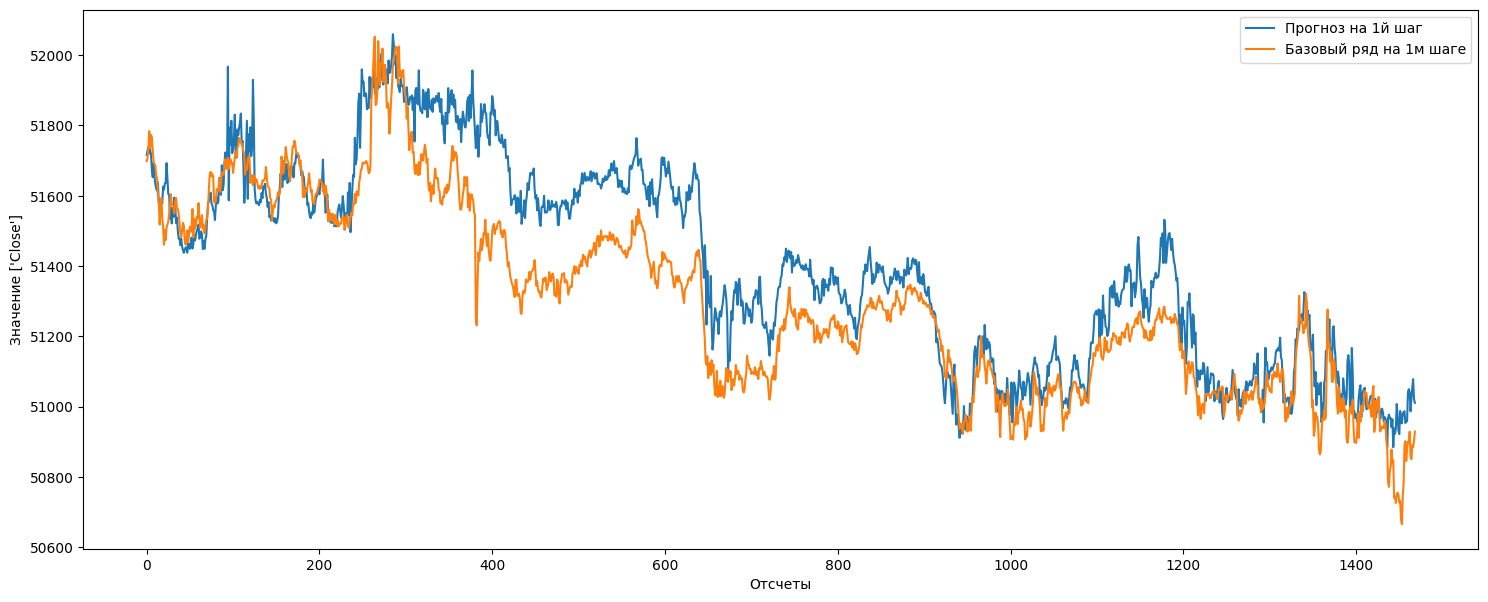

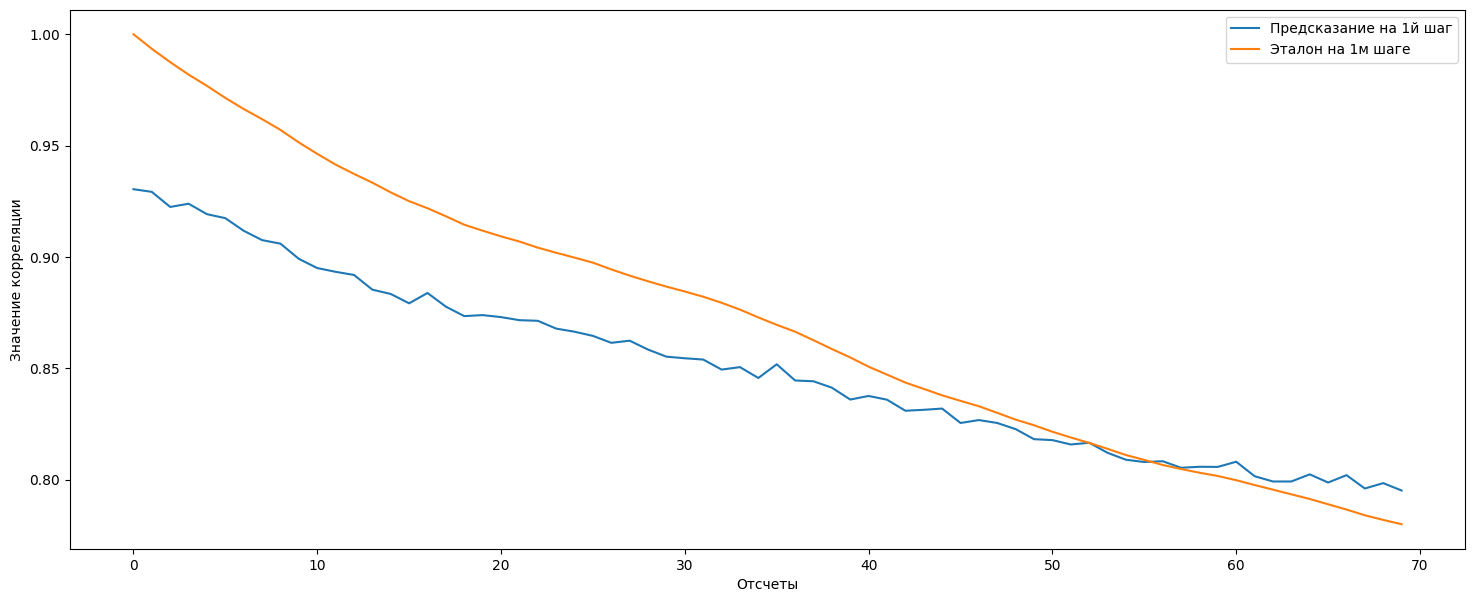

In [16]:
# Прогнозируем данные текущей сетью
(y_pred_test, y_true_test) = get_scalepred(model, XTEST, YTEST,
                                           Y_SCAILER) # Прогнозируем данные


# Отображаем графики
show_predict(0,                     # начало периода
             y_true_test.shape[0],  # конец периода
             [0],                   # по предсказанию на какие шаги отрисовываем
             y_pred_test,           # предчказанные цены
             y_true_test,           # реальные цены
             TARGET_COLS,
             figsize=(18,7))

# Отображаем корреляцию
# Проверяем корреляцию на глубину PREDICT_LAG шагов
auto_corr([0],              # по предсказанию на какие шаги отрисовываем корреляцию
          70,               # на сколько шагов предсказание
          y_pred_test,      # предчказанные цены
          y_true_test       # реальные цены
          )